In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import statsmodels.stats.api as sm
import statsmodels.stats.power as sp

plt.rc("figure", figsize=(16, 10))

In [2]:
class Exchange:
    COST = 0

    def sample(self):
        return self.COST + np.random.normal()


class TimeOfDayEffectWrapper:
    def __init__(self, exchange: Exchange):
        self.exchange = exchange

    def sample(self, tod="afternoon"):
        bias = 2.5 if tod == "morning" else 0.0
        return self.exchange.sample() + bias


class ASDAQ(Exchange):
    COST = 12


class BYSE(Exchange):
    COST = 10


def pprint(value):
    print("${:.2f}".format(value))


asdaq = ASDAQ()
pprint(asdaq.sample())

asdaq = TimeOfDayEffectWrapper(asdaq)
pprint(asdaq.sample("morning"))
pprint(asdaq.sample("afternoon"))

byse = TimeOfDayEffectWrapper(BYSE())
pprint(byse.sample())

$11.66
$18.27
$12.06
$10.52


In [3]:
pprint(np.mean([byse.sample() for _ in range(100)]))
pprint(np.mean([asdaq.sample() for _ in range(100)]))

$10.12
$12.02


In [4]:
def aggregate_measurements(n):
    return np.mean([byse.sample() for _ in range(n)])


print(np.std([aggregate_measurements(10) for _ in range(1000)]))
print(np.std([aggregate_measurements(100) for _ in range(1000)]))
print(np.std([aggregate_measurements(1000) for _ in range(1000)]))

0.31915404441380624
0.09594886072309623
0.03150064880547451


The more average measurements we take, the smaller the standard deviation.

In [5]:
alpha = 0.05
beta = 0.2

diff = 1
power = 1 - beta
n1 = sp.normal_sample_size_one_tail(
    diff, power, alpha, std_null=1, std_alternative=None
)
n1 = int(np.ceil(n1))
print("at least {} individual measurements are needed".format(n1))

at least 7 individual measurements are needed


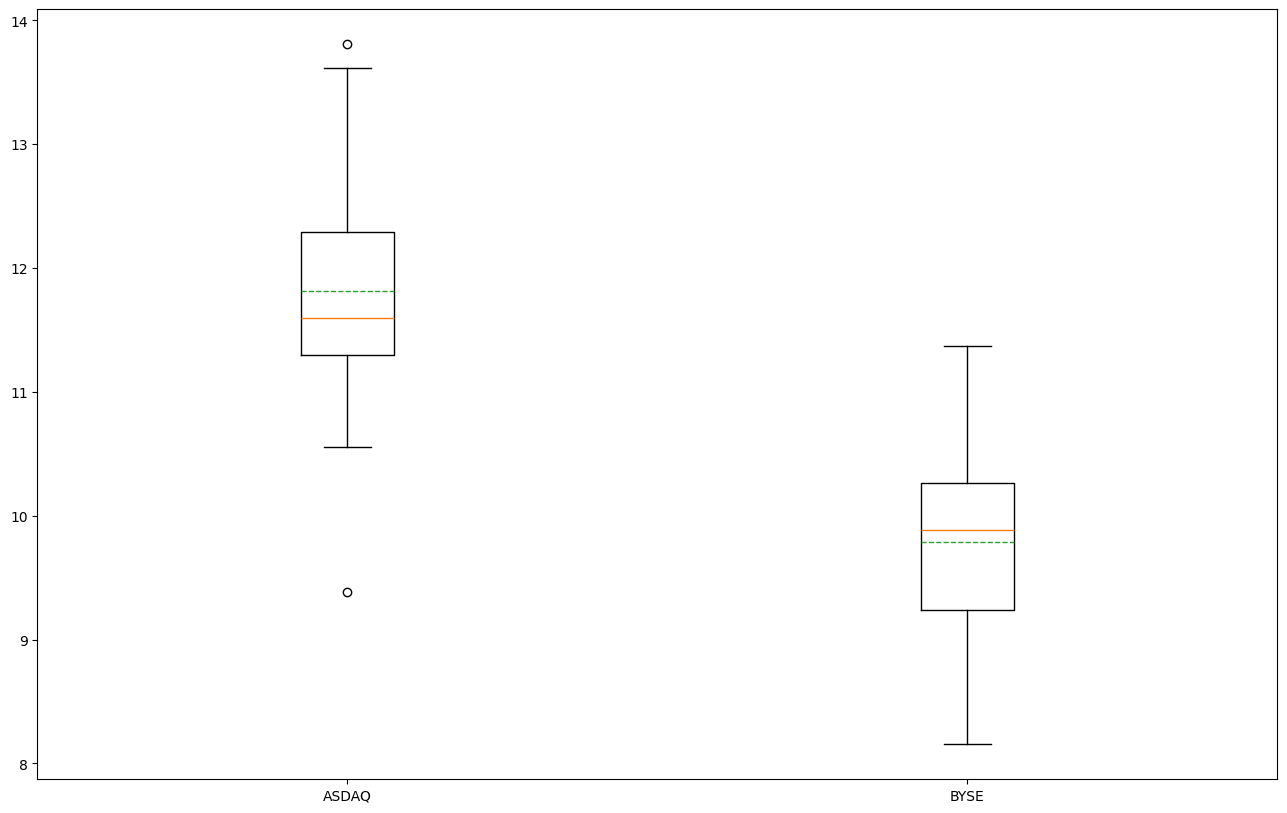

In [6]:
n = 30
asdaq_samples = []
byse_samples = []

# Randomly collecting samples for both ASDAQ and NYSE.
while len(asdaq_samples) < n or len(byse_samples) < n:
    if np.random.random() < 0.5:
        asdaq_samples.append(asdaq.sample())
    else:
        byse_samples.append(byse.sample())

plt.boxplot(
    [asdaq_samples, byse_samples],
    tick_labels=["ASDAQ", "BYSE"],
    showmeans=True,
    meanline=True,
);

In [7]:
sem = st.sem(asdaq_samples)
std = np.std(asdaq_samples)
mean = np.mean(asdaq_samples)
print("sem={:.4f} | std={:.4f} | mean={:.4f}".format(sem, std, mean))
print(len(asdaq_samples))

sem=0.1803 | std=0.9708 | mean=11.8170
30


In [8]:
sem = st.sem(byse_samples)
std = np.std(byse_samples)
mean = np.mean(byse_samples)
print("sem={:.4f} | std={:.4f} | mean={:.4f}".format(sem, std, mean))
print(len(byse_samples))

sem=0.1437 | std=0.7741 | mean=9.7907
30


In [9]:
# NOTE: The position of the X values are important.
# X1 - X2, for smaller alternative.
sample_size = 13
tstat, pvalue = sm.ztest(
    np.random.choice(asdaq_samples, sample_size),  # Control
    np.random.choice(byse_samples, sample_size),  # Treatment
    usevar="pooled",
    alternative="larger",
)
tstat, pvalue, pvalue < 0.05

(6.965917490529979, 1.6313516626215041e-12, True)

In [10]:
es = 1 / 1
alpha = 0.05
power = 0.8
sm.NormalIndPower().solve_power(
    effect_size=es,
    nobs1=None,
    alpha=alpha,
    power=power,
    ratio=1.0,
    alternative="larger",
)

12.365112414769648

In [11]:
sm.zt_ind_solve_power(
    effect_size=es,
    nobs1=None,
    alpha=alpha,
    power=power,
    ratio=1.0,
    alternative="larger",
)

12.365112414769648